In [ ]:
## Data Generation 

Daily Data Preview:
        date day_of_week  is_weekend  is_flash_sale  visitors  customers  \
0 2023-01-01      Sunday        True          False      1448         52   
1 2023-01-02      Monday       False           True       595         59   
2 2023-01-03     Tuesday       False          False      1060         31   
3 2023-01-04   Wednesday       False          False       946         24   
4 2023-01-05    Thursday       False           True      1697        148   

   conversion_rate  orders  orders_per_customer        aov       revenue  
0         0.035912      54             1.038462  49.308678   2662.668639  
1         0.099160     145             2.457627  40.367533   5853.292222  
2         0.029245      27             0.870968  52.572194   1419.449243  
3         0.025370      26             1.083333  44.823788   1165.418498  
4         0.087213     382             2.581081  36.933991  14108.784378  

Flash Sale Days:
[Timestamp('2023-01-02 00:00:00'), Timestamp('2023-01-0

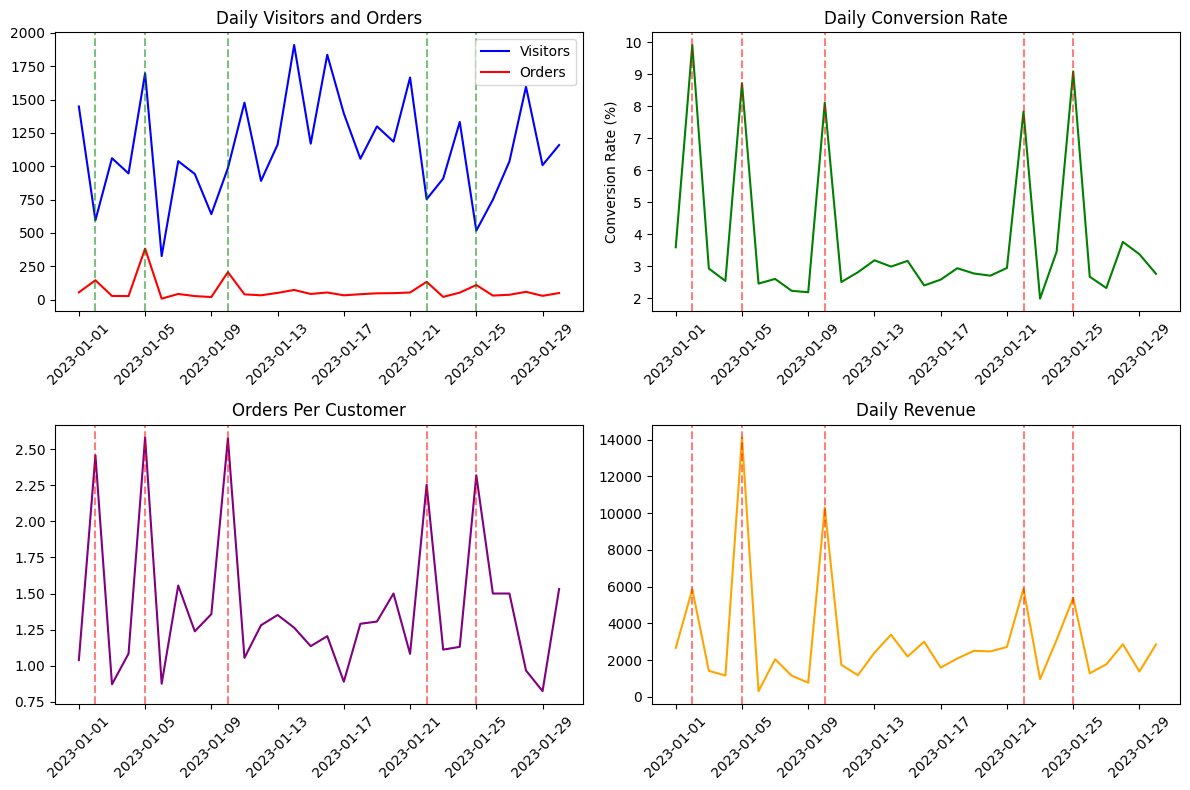

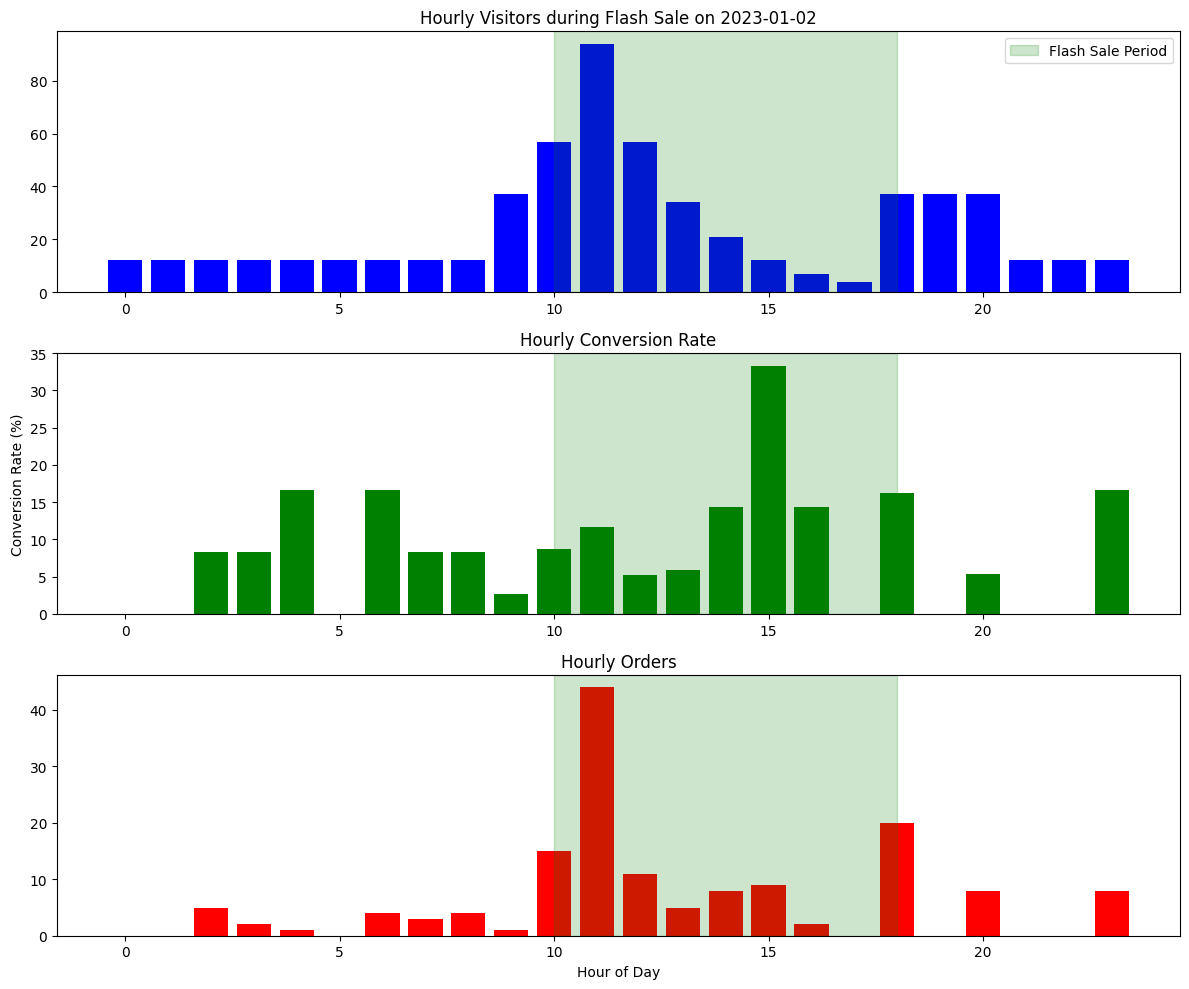

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

def generate_flash_sale_data(days=30, sale_days=5, visitors_base=1000, visitors_scale=500, 
                             conversion_base=0.03, conversion_spike=0.08, 
                             orders_per_customer_base=1.2, orders_per_customer_spike=2.5):
    """
    Generate synthetic data for e-commerce flash sales over a specified period.
    
    Parameters:
    - days: Total number of days to simulate
    - sale_days: Number of flash sale days within the total period
    - visitors_base: Average number of visitors on normal days
    - visitors_scale: Scale parameter for visitor count variation
    - conversion_base: Base conversion rate (probability of purchase) on normal days
    - conversion_spike: Increased conversion rate during flash sales
    - orders_per_customer_base: Average orders per customer on normal days
    - orders_per_customer_spike: Average orders per customer during flash sales
    
    Returns:
    - DataFrame with daily visitor and order data
    - DataFrame with hourly data for flash sale days
    """
    # Create date range
    start_date = datetime(2023, 1, 1)
    dates = [start_date + timedelta(days=i) for i in range(days)]
    
    # Randomly select flash sale days (excluding the first and last day)
    flash_sale_indices = sorted(random.sample(range(1, days-1), sale_days))
    flash_sale_dates = [dates[i] for i in flash_sale_indices]
    
    # Generate daily data
    daily_data = []
    hourly_data = []
    
    for i, date in enumerate(dates):
        is_flash_sale = date in flash_sale_dates
        is_weekend = date.weekday() >= 5
        
        # Base visitor count with some randomness
        daily_visitors_base = visitors_base * (1.2 if is_weekend else 1.0)
        daily_visitors = int(np.random.normal(daily_visitors_base, visitors_scale))
        
        # Conversion rate (probability of a visitor making a purchase)
        conversion_rate = conversion_spike if is_flash_sale else conversion_base
        conversion_rate *= (1.1 if is_weekend else 1.0)  # Higher on weekends
        
        # Binomial distribution for number of customers who make a purchase
        customers = np.random.binomial(daily_visitors, conversion_rate)
        
        # Poisson distribution for orders per customer
        orders_lambda = orders_per_customer_spike if is_flash_sale else orders_per_customer_base
        total_orders = np.random.poisson(orders_lambda, customers).sum() if customers > 0 else 0
        
        # Average order value
        aov_base = 50.0
        aov_discount = 0.85 if is_flash_sale else 1.0  # 15% discount during flash sales
        aov = aov_base * aov_discount * np.random.normal(1.0, 0.1)  # Add some randomness
        
        revenue = total_orders * aov
        
        daily_data.append({
            'date': date,
            'day_of_week': date.strftime('%A'),
            'is_weekend': is_weekend,
            'is_flash_sale': is_flash_sale,
            'visitors': daily_visitors,
            'customers': customers,
            'conversion_rate': customers / daily_visitors if daily_visitors > 0 else 0,
            'orders': total_orders,
            'orders_per_customer': total_orders / customers if customers > 0 else 0,
            'aov': aov,
            'revenue': revenue
        })
        
        # Generate hourly data for flash sale days
        if is_flash_sale:
            # Flash sale starts at 10:00 AM and lasts for 8 hours
            flash_sale_start = 10
            flash_sale_duration = 8
            
            # Traffic distribution throughout the day (24 hours)
            hourly_traffic_dist = np.zeros(24)
            
            # Base traffic distribution (higher during business hours)
            for h in range(24):
                if 9 <= h < 21:  # Business hours
                    hourly_traffic_dist[h] = 0.06
                else:
                    hourly_traffic_dist[h] = 0.02
            
            # Enhanced traffic during flash sale hours
            peak_time = flash_sale_start + 1  # Peak traffic 1 hour after start
            
            for h in range(flash_sale_start, flash_sale_start + flash_sale_duration):
                # Distance from peak (in hours)
                distance = abs(h - peak_time)
                # Exponential decay from peak
                if h < 24:  # Ensure we don't go beyond 24 hours
                    hourly_traffic_dist[h] = 0.15 * np.exp(-0.5 * distance)
            
            # Normalize distribution
            hourly_traffic_dist = hourly_traffic_dist / hourly_traffic_dist.sum()
            
            # Generate hourly visitors and orders
            for hour in range(24):
                hour_visitors = int(daily_visitors * hourly_traffic_dist[hour])
                
                # Higher conversion during flash sale hours
                hour_conversion = conversion_rate
                if flash_sale_start <= hour < flash_sale_start + flash_sale_duration:
                    # Conversion peaks in the middle of the flash sale
                    hour_position = (hour - flash_sale_start) / flash_sale_duration
                    # Bell curve peaking in the middle of the flash sale
                    conversion_multiplier = np.exp(-16 * (hour_position - 0.5)**2)
                    hour_conversion = conversion_rate * (1 + conversion_multiplier)
                    
                hour_customers = np.random.binomial(hour_visitors, hour_conversion)
                
                # Poisson for orders
                hour_orders_lambda = orders_lambda
                if flash_sale_start <= hour < flash_sale_start + flash_sale_duration:
                    # Orders per customer peaks early in the flash sale
                    hour_position = (hour - flash_sale_start) / flash_sale_duration
                    # Exponential decay from start
                    orders_multiplier = np.exp(-2 * hour_position)
                    hour_orders_lambda = orders_lambda * (1 + orders_multiplier * 0.5)
                
                hour_orders = np.random.poisson(hour_orders_lambda, hour_customers).sum() if hour_customers > 0 else 0
                
                hourly_data.append({
                    'date': date,
                    'hour': hour,
                    'is_flash_sale_hour': flash_sale_start <= hour < flash_sale_start + flash_sale_duration,
                    'visitors': hour_visitors,
                    'customers': hour_customers,
                    'conversion_rate': hour_customers / hour_visitors if hour_visitors > 0 else 0,
                    'orders': hour_orders,
                    'orders_per_customer': hour_orders / hour_customers if hour_customers > 0 else 0
                })
    
    return pd.DataFrame(daily_data), pd.DataFrame(hourly_data)

# Generate the data
daily_data, hourly_data = generate_flash_sale_data()

# Save the data to CSV files
daily_data.to_csv('flash_sale_daily_data.csv', index=False)
hourly_data.to_csv('flash_sale_hourly_data.csv', index=False)

# Preview the data
print("Daily Data Preview:")
print(daily_data.head())
print("\nFlash Sale Days:")
print(daily_data[daily_data['is_flash_sale']]['date'].tolist())
print("\nHourly Data Preview (for flash sale days):")
print(hourly_data[hourly_data['is_flash_sale_hour']].head())

# Generate some basic visualizations
plt.figure(figsize=(12, 8))

# Daily visitors and orders
plt.subplot(2, 2, 1)
plt.title('Daily Visitors and Orders')
plt.plot(daily_data['date'], daily_data['visitors'], 'b-', label='Visitors')
plt.plot(daily_data['date'], daily_data['orders'], 'r-', label='Orders')
for date in daily_data[daily_data['is_flash_sale']]['date']:
    plt.axvline(x=date, color='g', linestyle='--', alpha=0.5)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Conversion rate
plt.subplot(2, 2, 2)
plt.title('Daily Conversion Rate')
plt.plot(daily_data['date'], daily_data['conversion_rate'] * 100, 'g-')
for date in daily_data[daily_data['is_flash_sale']]['date']:
    plt.axvline(x=date, color='r', linestyle='--', alpha=0.5)
plt.ylabel('Conversion Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()

# Orders per customer
plt.subplot(2, 2, 3)
plt.title('Orders Per Customer')
plt.plot(daily_data['date'], daily_data['orders_per_customer'], 'purple')
for date in daily_data[daily_data['is_flash_sale']]['date']:
    plt.axvline(x=date, color='r', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

# Revenue
plt.subplot(2, 2, 4)
plt.title('Daily Revenue')
plt.plot(daily_data['date'], daily_data['revenue'], 'orange')
for date in daily_data[daily_data['is_flash_sale']]['date']:
    plt.axvline(x=date, color='r', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('flash_sale_daily_overview.png')

# Hourly analysis for a flash sale day
flash_sale_date = daily_data[daily_data['is_flash_sale']]['date'].iloc[0]
hourly_for_day = hourly_data[hourly_data['date'] == flash_sale_date]

plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.title(f'Hourly Visitors during Flash Sale on {flash_sale_date.strftime("%Y-%m-%d")}')
plt.bar(hourly_for_day['hour'], hourly_for_day['visitors'], color='blue')
plt.axvspan(10, 18, alpha=0.2, color='green', label='Flash Sale Period')
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Hourly Conversion Rate')
plt.bar(hourly_for_day['hour'], hourly_for_day['conversion_rate'] * 100, color='green')
plt.axvspan(10, 18, alpha=0.2, color='green')
plt.ylabel('Conversion Rate (%)')

plt.subplot(3, 1, 3)
plt.title('Hourly Orders')
plt.bar(hourly_for_day['hour'], hourly_for_day['orders'], color='red')
plt.axvspan(10, 18, alpha=0.2, color='green')
plt.xlabel('Hour of Day')

plt.tight_layout()
plt.savefig('flash_sale_hourly_analysis.png')

print("\nData generation and visualization complete!")